In [8]:
#import libraries
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load the raw dataset using pipe delimiter
data = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep="|", low_memory=False)
data.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [21]:
# Create a LossRatio column
# This column is essential for comparing claim behavior across groups
# Adding a small value (e.g., 1e-6) to avoid division by zero if TotalPremium has zeros
data["LossRatio"] = data["TotalClaims"] / (data["TotalPremium"] + 1e-6)

In [22]:
# Create HasClaim: a binary indicator if the policyholder had any claims
data["HasClaim"] = data["TotalClaims"] > 0

# Hypothesis Test

## Hypothesis 1: Risk Differences Across Provinces
If p<0.05, we reject meaning there are statistically significant differences in risk across provinces. 
This would justify provincial adjustment of premiums.
"""

In [32]:
# We compare claim frequencies across provinces.
province_claims = pd.crosstab(data["Province"], data["HasClaim"])
chi2, p, dof, _ = stats.chi2_contingency(province_claims)
print(f"Chi-squared test for province vs claims: p-value = {p:.5f}")


Chi-squared test for province vs claims: p-value = 0.00000


'\nInterpretation: If , we reject , meaning there are statistically significant differences in risk across provinces. \nThis would justify provincial adjustment of premiums.\n'

# Hypothesis 2: Risk Differences Between ZIP Codes
If p<0.05, there are significant risk differences between these ZIP codes, possibly warranting micro-segmentation in premium pricing.

In [33]:
# Due to the granularity of ZIP codes, we select the top two with the most observations.
zip_counts = data["PostalCode"].value_counts()
top_zips = zip_counts.nlargest(2).index.tolist()
zip_sample = data[data["PostalCode"].isin(top_zips)]

In [34]:
# Compare claim frequency
zip_contingency = pd.crosstab(zip_sample["PostalCode"], zip_sample["HasClaim"])
chi2_zip, p_zip, _, _ = stats.chi2_contingency(zip_contingency)
print(f"Chi-squared test for ZIP vs claims: p-value = {p_zip:.5f}")

Chi-squared test for ZIP vs claims: p-value = 0.05788


# Hypothesis 3: Margin Differences Between ZIP Codes
Rejecting the null hypothesis here implies profitability differs significantly between ZIP codes, suggesting a review of pricing strategy by geography.

In [36]:
# Filter the top ZIP codes and compute margin
zip_sample.loc[:, "Margin"] = zip_sample["TotalPremium"] - zip_sample["TotalClaims"]
zip1, zip2 = top_zips

margin1 = zip_sample[zip_sample["PostalCode"] == zip1]["Margin"].dropna()
margin2 = zip_sample[zip_sample["PostalCode"] == zip2]["Margin"].dropna()

stat, p_margin = stats.ttest_ind(margin1, margin2, equal_var=False)
print(f"T-test for margin differences between ZIPs: p-value = {p_margin:.5f}")

T-test for margin differences between ZIPs: p-value = 0.24446


# Hypothesis 4: Gender-Based Risk Differences
If we reject , it implies male and female customers have statistically different risk profiles, which could support gender-specific pricing or marketing strategies.

In [ ]:
# Compare claim frequency between genders
gender_ct = pd.crosstab(data["Gender"], data["HasClaim"])
chi2_gender, p_gender, _, _ = stats.chi2_contingency(gender_ct)
print(f"Chi-squared test for gender vs claims: p-value = {p_gender:.5f}")

In [ ]:
Additional statistics

In [37]:
# Cramér's V for chi-squared test
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


In [38]:
# Loss ratio by province
province_risk = data.groupby("Province")["LossRatio"].mean().sort_values(ascending=False)
print(province_risk)

Province
Free State       1.098251e+07
KwaZulu-Natal    4.564885e+06
Gauteng          3.587203e+06
North West       2.278835e+06
Limpopo          9.898431e+05
Western Cape     8.636677e+05
Eastern Cape     3.335613e+05
Mpumalanga       1.684981e+05
Northern Cape    1.163881e-01
Name: LossRatio, dtype: float64


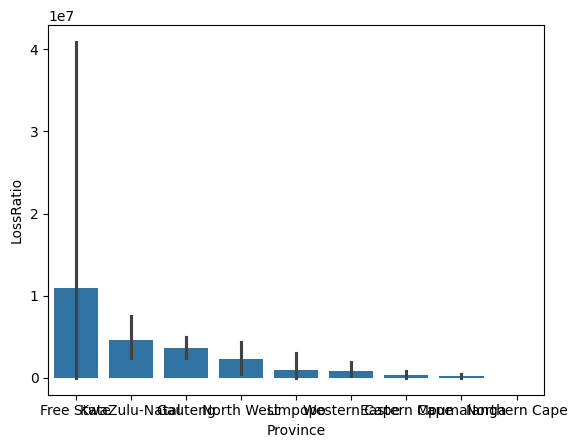

In [40]:
sns.barplot(data=data, x="Province", y="LossRatio", order=province_risk.index)
plt.show()